To run this notebook, in addition to the standard Anaconda packages, you must also install community-simulator (https://github.com/Emergent-Behaviors-in-Biology/community-simulator), scikit-learn (https://anaconda.org/anaconda/scikit-learn) and scikit-bio (https://anaconda.org/anaconda/scikit-bio). Always frun the following cell first, to get all the key imports and definitions:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.backends import backend_pdf as bpdf
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics,MakeMatrices,MakeInitialState,BinaryRandomMatrix
from community_simulator import Community
from community_simulator.visualization import PlotTraj, StackPlot
import pickle
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa
from scipy.optimize import minimize
from scipy.stats import norm

#Functions for inverting some things
def w0(Delta):
    return norm.cdf(Delta)
def err_fisher(alpha,params):
    S = params[0]
    N = params[1]
    x = 1-np.exp(-S/alpha)
    return (N-(alpha*x/(1-x)))**2
def err_w(DelN,phiN):
    return (phiN-w0(DelN))**2
#Loading data
folder = 'data/'
def filename(kind,exp,S,folder = folder):
    if kind == 'comm':
        suff = '.dat'
    else:
        suff = '.csv'
    return folder+'_'.join([kind]+exp.split(' ')+['S'])+str(S)+suff

colors = sns.color_palette()

#Construct dynamics
mp = {
      'regulation':'independent',
      'supply':'external',
      'response':'type I'
     }
def dNdt(N,R,params):
    return MakeConsumerDynamics(mp)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(mp)(N,R,params)
dynamics = [dNdt,dRdt]

%matplotlib inline

# Colonization Dynamics

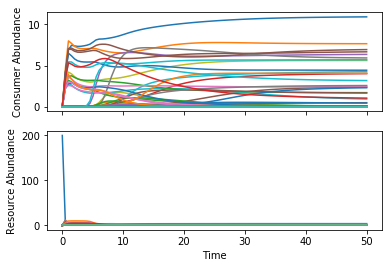

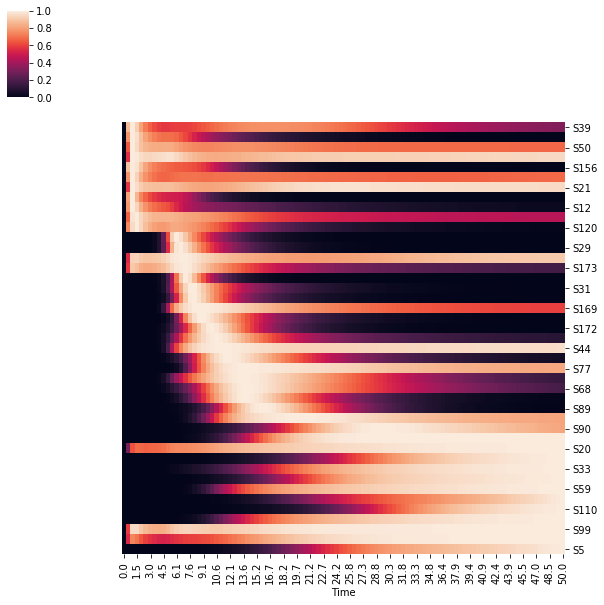

In [33]:
exp = 'Simple environment'
with open(filename('comm',exp,150),'rb') as f:
    N,R,params,R0,metadata = pickle.load(f)

N0 = np.ones(len(N))*1e-6
test_colony = Community([N0,R0.values[:,0]],dynamics,params)

out = test_colony.TestWell(T = 50)
Ntraj = pd.DataFrame(out[1],index = pd.Series(np.around(out[0],decimals=1),name='Time'),columns = test_colony.N.index).T
Ntraj = Ntraj.loc[Ntraj.T.max()>0.01]
t_max = np.argmax(Ntraj.values,axis=1)
Ntraj['t_max'] = t_max
Ntraj = Ntraj.sort_values('t_max')
del Ntraj['t_max']
sns.clustermap(Ntraj,col_cluster=False,row_cluster=False,standard_scale=0)
plt.show()

# Matrices

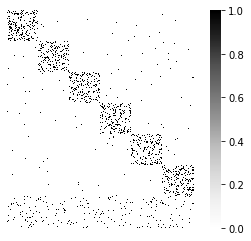

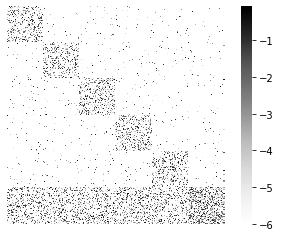

In [34]:
exp = 'Simple environments'
S = 2500
with open(filename('comm',exp,S),'rb') as f:
    N,R,params,R0,metadata = pickle.load(f)

c = pd.DataFrame(params['c'],index=N.index,columns=R.index)
families = c.index.levels[0]
c_red = c.loc[families[0]].iloc[:50]
for fname in families[1:]:
    ctemp = c.loc[fname].iloc[:50]
    c_red = c_red.append(ctemp)
    
    
fig,ax=plt.subplots()
sns.heatmap(c_red,cmap='Greys',vmin=0,square=True,xticklabels=False,yticklabels=False,cbar=True,ax=ax)
ax.set_xlabel('')
plt.show()

fig,ax=plt.subplots()
sns.heatmap(np.log10(params['D']+1e-6),cmap='Greys',square=True,xticklabels=False,yticklabels=False,cbar=True,ax=ax)
plt.show()

# Patterns in Global Microbial Biodiversity

## Determine threshold for removing solver noise

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


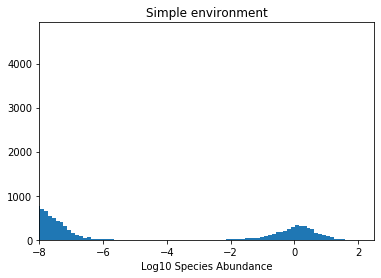

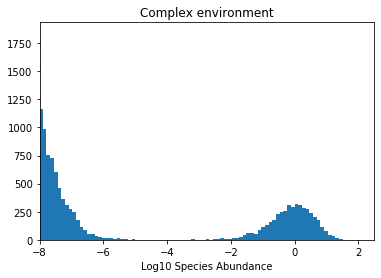

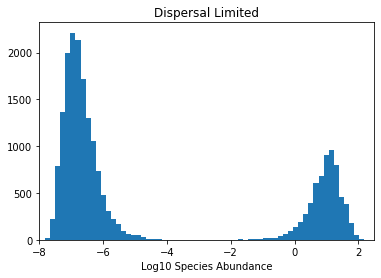

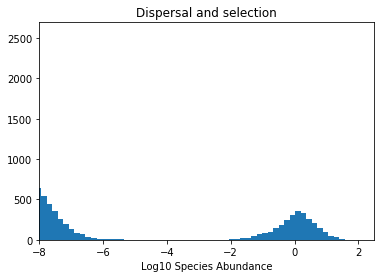

In [9]:
for exp in ['Simple environment', 'Complex environment', 'Dispersal Limited', 'Dispersal and selection']:
    if exp == 'Dispersal Limited':
        S = 'rand'
    else:
        S = 150
    N = pd.read_csv(filename('N',exp,S),index_col=[0,1]).values.reshape(-1)
    plt.hist(np.log10(N[N>0]),bins=100)
    plt.gca().set_xlim((-8,2.5))
    plt.gca().set_title(exp)
    plt.gca().set_xlabel('Log10 Species Abundance')
    plt.show()

## Plot richness vs. harshness

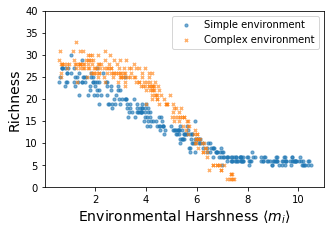

In [10]:
thresh = 1e-4
fig,ax=plt.subplots(figsize=(5,3.5))
fig.subplots_adjust(bottom=0.18)
ms = ['o','x']
k=0
for exp in ['Simple environment','Complex environment']:
    N = pd.read_csv(filename('N',exp,150),index_col=[0,1])
    metadata = pd.read_csv(filename('m',exp,150),index_col=0)
    metadata = metadata[N.max()<1e7]
    N = N.T[N.max()<1e7].T
    metadata = metadata[np.isnan(N).sum()==0]
    N = N.T[np.isnan(N).sum()==0].T
    richness = (N > thresh).sum()
    ax.scatter(metadata['m'].values[richness>0],richness[richness>0],color=colors[k],s=10,alpha=0.6,marker=ms[k],label=exp)
    k+=1
ax.legend()
ax.set_xlabel(r'Environmental Harshness $\langle m_i \rangle$',fontsize=14)
ax.set_ylabel('Richness',fontsize=14)
ax.set_ylim((0,40))
pdf = bpdf.PdfPages('plots/harshness_variation.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Plot nestedness and quantify

In [11]:
def PlotNestedness(N,well=None,thresh=0,ax=None):
    
    species_exist = N > thresh

    prevalence = species_exist.T.sum()
    richness = species_exist.sum()

    species_exist = species_exist.loc[prevalence > 0]
    prevalence = prevalence.loc[prevalence > 0]

    names = np.array(list(zip(species_exist.keys(),richness)),dtype=[('well','S100'),('richness',int)])
    names_sort = np.asarray(np.sort(names,order='richness')['well'],dtype=str)

    species = np.array(list(zip(np.arange(len(species_exist)),prevalence)),dtype=[('species',int),('prevalence',int)])
    species_sort = np.asarray(np.sort(species,order='prevalence')['species'],dtype=int)
    
    if ax is None:
        fig,ax=plt.subplots()
    N_sort = np.flipud(np.asarray(species_exist[names_sort].iloc[species_sort].values,dtype=int))
    sns.heatmap(N_sort,ax=ax,cmap=sns.color_palette("Greys",30),cbar=False)
    ax.set_yticks(())
    ax.set_xticks(())
    ax.set_xlabel('Samples (sorted by richness)',fontsize=12)
    ax.set_ylabel('Species (sorted by prevalence)',fontsize=12)
    
    return ax, N_sort

def NODF(A):
    m,n = np.shape(A)
    Ac = np.ones((n,n))*A.sum(axis=0)
    Ar = np.ones((m,m))*A.T.sum(axis=0)
    Dr = Ar<Ar.T
    Dc = Ac<Ac.T
    B = ((A.T)/(A.T.sum(axis=0))).T
    C = A/A.sum(axis=0)
    
    return 2*(np.trace(A.T.dot(Dr.dot(B)))+np.trace(A.dot(Dc.dot(C.T))))/(n*(n-1)+m*(m-1))

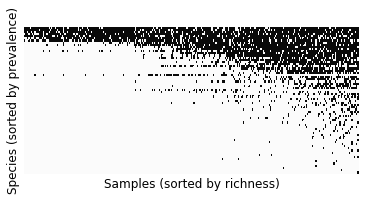

0.7198696087446625


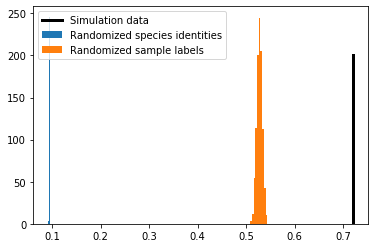

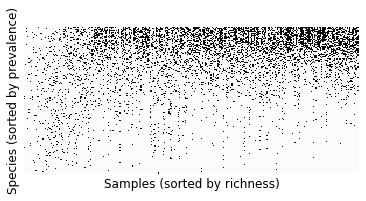

0.22829644879980632


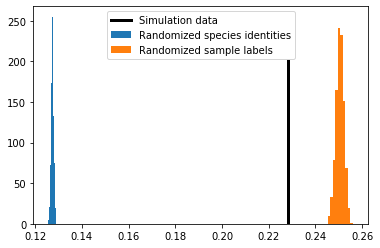

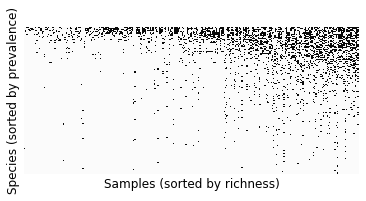

0.308632237307596


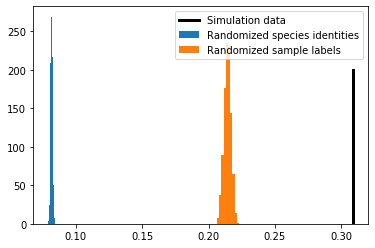

In [12]:
for exp in ['Simple environment','Dispersal limited','Dispersal and selection']:
    if exp == 'Simple environment':
        S = 150
        thresh = 1e-4
    else:
        S = 'rand'
        thresh = 1e-3
    N = pd.read_csv(filename('N',exp,S),index_col=[0,1])
    N = N.T[N.max()<1e7].T
    N = N.T[np.isnan(N).sum()==0].T
    fig,ax=plt.subplots(figsize = (6,2.7))
    ax,N_sort = PlotNestedness(N,ax=ax,thresh=thresh)
    pdf = bpdf.PdfPages('plots/nestedness_'+'_'.join(exp.split(' '))+'.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()

    Q = 1000
    null1 = []
    null2 = []

    for j in range(Q):
        null = N.values.copy()>thresh
        for k in range(len(null.T)):
            null[:,k] = np.random.permutation(null[:,k])
        null = null[null.sum(axis=1)>0,:]
        null = null[:,null.sum(axis=0)>0]
        null1.append(NODF(null))
    
        null = N.values.copy()>thresh
        for k in range(len(null)):
            null[k,:] = np.random.permutation(null[k,:])
        null = null[null.sum(axis=1)>0,:]
        null = null[:,null.sum(axis=0)>0]
        null2.append(NODF(null))
    
    NODF_data = NODF(N.loc[N.sum(axis=1)>thresh].T.loc[N.sum(axis=0)>thresh].T.values>thresh)
    print(NODF_data)

    fig,ax=plt.subplots()
    ax.hist(null1,label='Randomized species identities')
    ax.hist(null2,label='Randomized sample labels')
    ax.plot([NODF_data,NODF_data],[0,200],'k',linewidth=3,label='Simulation data')
    ax.legend()
    pdf = bpdf.PdfPages('plots/NODF_'+'_'.join(exp.split(' '))+'.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()

# Abundance Distributions

## Tara Oceans

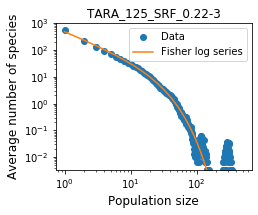

In [52]:
#Load ocean data
ocean = pd.read_csv('data/Tara-Ocean/tara_ocean.tsv',header=0,index_col=[0,1,2,3,4,5,6],sep='\t')
#ocean[ocean<100] = 0
ocean.index = ['S'+str(k) for k in range(len(ocean))]
ocean = ocean.reindex(np.random.choice(ocean.index,size=len(ocean.index),replace=False))

#Select random sample from the dataset:
#well = ocean.T.index[np.random.randint(len(ocean.T))]
#This is the one used in the paper:
well = 'TARA_125_SRF_0.22-3' 

#Sample
Ntot = 10000
n_trials = 300
bins = np.arange(500)+0.5
counts = np.zeros(len(bins)-1)
for k in range(n_trials):
    #populations = np.random.poisson(ocean[well].values*Ntot/ocean[well].sum())
    populations = np.random.multinomial(Ntot,ocean[well].values/ocean[well].sum())
    counts += np.histogram(populations,bins=bins,density=False)[0]/n_trials
    
#Compute parameters for Fisher log series
thresh = 5
S_survive = (ocean[well]>thresh).sum()
out=minimize(err_fisher,300,args=([S_survive,Ntot],))
alpha = out.x
p = 1-np.exp(-S_survive/alpha)
x_axis = bins[:-1]+0.5

#Plot
fig,ax = plt.subplots(figsize=(4,3))
fig.subplots_adjust(left=0.22,bottom=0.2)
ax.loglog(x_axis,counts,'o',label='Data')
ax.loglog(x_axis,alpha*p**(x_axis)/x_axis,label='Fisher log series')
ax.set_ylim((1/n_trials,1000))
ax.set_xlabel('Population size',fontsize=12)
ax.set_ylabel('Average number of species',fontsize=12)
ax.set_title(well)
plt.legend()
pdf = bpdf.PdfPages('Plots/RAD_Tara_'+well+'.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

In [26]:
ocean['TARA_125_SRF_0.22-3'].sum()

129135

## Simulation

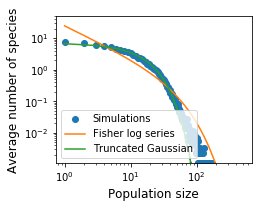

In [54]:
#Load data
S = 2500
exp = 'No taxonomic structure'
thresh = 1e-4
with open(filename('comm',exp,S),'rb') as f:
    N,R,params,R0,metadata = pickle.load(f)
#Drop trials that failed
metadata = metadata.loc[N.sum()>0]
R0 = R0.T.loc[N.sum()>0].T
N = N.T.loc[N.sum()>0].T

#Sample from population
Ntot = 1000
wells = metadata.index
n_wells = len(wells)
bins = np.arange(500)+0.5
counts = np.zeros(len(bins)-1)
for well in wells:
    #populations = np.random.poisson(N[well].values*Ntot/N[well].sum())
    populations = np.random.multinomial(Ntot,N[well].values/N[well].sum())
    counts += np.histogram(populations,bins=bins,density=False)[0]/n_wells
    
#Compute parameters for Fisher log series
S_survive = (N[wells]>thresh).sum().mean()
out=minimize(err_fisher,100,args=([S_survive,Ntot],))
alpha = out.x
p = 1-np.exp(-S_survive/alpha)
x_axis = bins[:-1]+0.5

#Compute results from truncated Gaussian with same parameters
n_trials = 10000
counts_trunc = np.zeros(len(bins)-1)
DelN = minimize(err_w,0,args=(S_survive/S,)).x[0]
for trial in range(n_trials):
    N_trunc = np.random.randn(S) + DelN
    N_trunc[N_trunc<0] = 0
    #populations = np.random.poisson(N_trunc*Ntot/N_trunc.sum())
    populations = np.random.multinomial(Ntot,N_trunc/N_trunc.sum())
    counts_trunc += np.histogram(populations,bins=bins,density=False)[0]/n_trials
    
#Plot
fig,ax = plt.subplots(figsize=(4,3))
fig.subplots_adjust(left=0.22,bottom=0.2)
ax.loglog(x_axis,counts,'o',label='Simulations')
ax.loglog(x_axis,alpha*p**(x_axis)/x_axis,label='Fisher log series')
ax.loglog(x_axis,counts_trunc,label='Truncated Gaussian')
ax.set_ylim((1/n_wells,50))
ax.set_xlabel('Population size',fontsize=12)
ax.set_ylabel('Average number of species',fontsize=12)
plt.legend(loc=3)
pdf = bpdf.PdfPages('Plots/RAD_'+'_'.join(exp.split(' ')+['S',str(S)])+'.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Mixture of truncated Gaussians

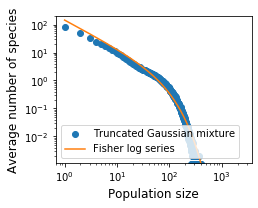

In [175]:
F = 3
DelN = -2.5*np.ones(F)
S = int(100000/F)*np.ones(F,dtype=int)
Ntot = 10000
sigmaN = (.05*Ntot)**(np.arange(1,F+1)/F)
n_trials = 1000
bins = np.arange(2500)+0.5
counts = np.zeros(len(bins)-1)
for trial in range(n_trials):
    N = []
    for k in range(len(DelN)):
        N = N + list(sigmaN[k]*(np.random.randn(S[k]) + DelN[k]))
    N = np.asarray(N)
    N[N<0] = 0
    #populations = np.random.poisson(N*Ntot/N.sum())
    populations = np.random.multinomial(Ntot,N/N.sum())
    counts += np.histogram(populations,bins=bins,density=False)[0]/n_trials
#Compute parameters for Fisher log series
S_survive = np.sum([w0(DelN[k])*S[k] for k in range(len(S))])
out=minimize(err_fisher,100,args=([S_survive,Ntot],))
alpha = out.x
p = 1-np.exp(-S_survive/alpha)
x_axis = bins[:-1]+0.5

#Compute results from truncated Gaussian with same parameters
#S = np.sum(S)
#n_trials = 10000
#counts_trunc = np.zeros(len(bins)-1)
#DelN = minimize(err_w,0,args=(S_survive/S,)).x[0]
#for trial in range(n_trials):
#    N_trunc = np.random.randn(S) + DelN
#    N_trunc[N_trunc<0] = 0
#    #populations = np.random.poisson(N_trunc*Ntot/N_trunc.sum())
#    populations = np.random.multinomial(Ntot,N_trunc/N_trunc.sum())
#    counts_trunc += np.histogram(populations,bins=bins,density=False)[0]/n_trials
    
#Plot
fig,ax = plt.subplots(figsize=(4,3))
fig.subplots_adjust(left=0.22,bottom=0.2)
ax.loglog(x_axis,counts,'o',label='Truncated Gaussian mixture')
ax.loglog(x_axis,alpha*p**(x_axis)/x_axis,label='Fisher log series')
#ax.loglog(x_axis,counts_trunc,label='Truncated Gaussian')
ax.set_ylim((1/n_wells,200))
ax.set_xlabel('Population size',fontsize=12)
ax.set_ylabel('Average number of species',fontsize=12)
plt.legend(loc=3)
pdf = bpdf.PdfPages('Plots/RAD_test.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Patterns in the Human Microbiome

For these simulations, we focus on the role of the externally supplied nutrients (e.g., diet) in the production of inter-subject compositional variability. We consider a regional pool of 5,000 species (approximately the number of OTU's in the HMP), with 300 resources (approximately the number of metabolites in E. Coli metabolism) and metabolic network sparsity $s=0.3$ chosen to obtain approximately the mean degree of $\bar{k}=4.76$ of the E. Coli metabolic network ([A. Wagner and D.A. Fell, <i>Proc. R. Soc. Lond. B</i>, <b>268</b>:1803, 2001](https://royalsocietypublishing.org/doi/pdf/10.1098/rspb.2001.1711)). Although none of the entries of $D_{\alpha\beta}$ are exactly zero, we can measure the effective number of species using the inverse Simpson index of each column, which would give the connectivity if all the nonzero connections had the same weight:

In [14]:
S = 2500
exp = 'Simple environments'
with open(filename('comm',exp,S),'rb') as f:
    N,R,params,R0,metadata = pickle.load(f)
print(np.mean(1/(params['D']**2).sum(axis=0)))

4.834223085526203


## Main plots

thresh = 0.0031622776601683794
-------------------Simple environments-------------------


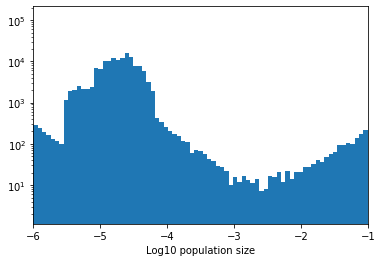

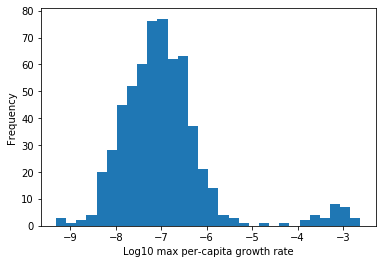

29


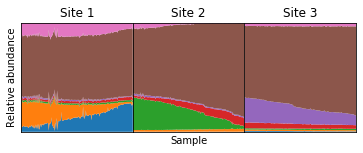

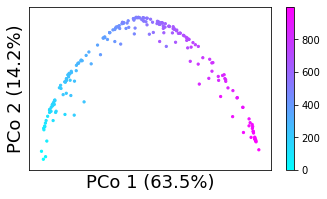

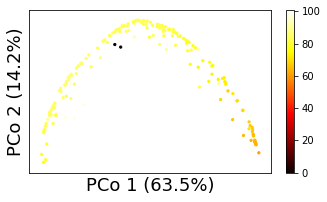

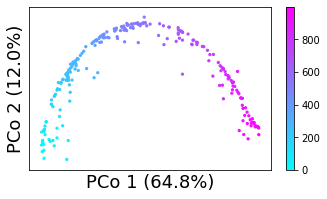

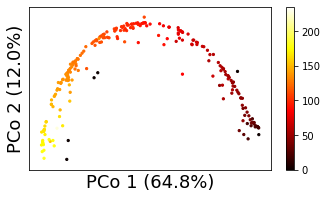

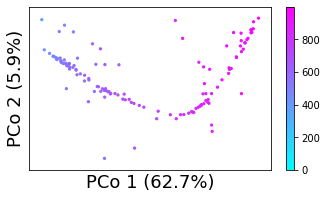

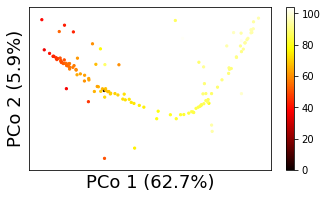

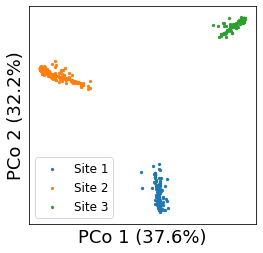

-------------------Complex environments-------------------


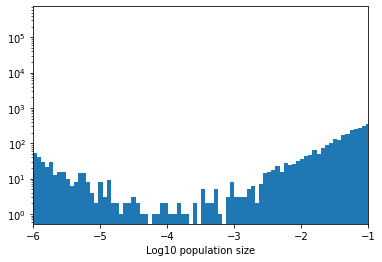

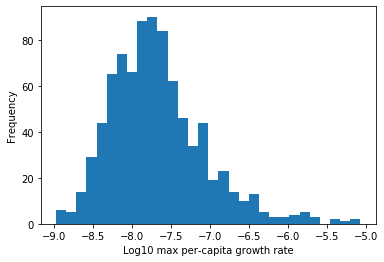

0


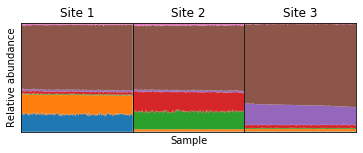

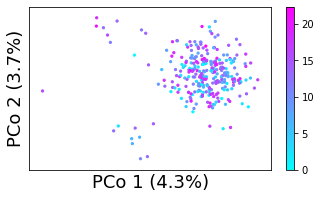

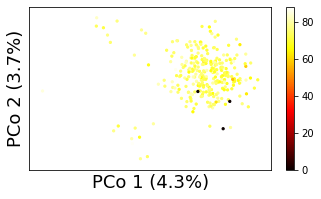

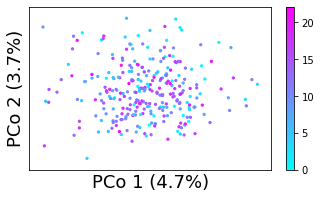

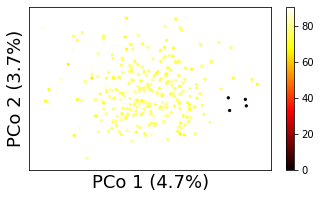

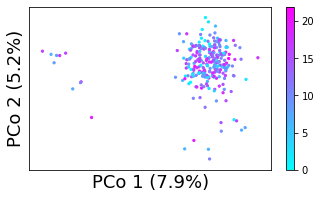

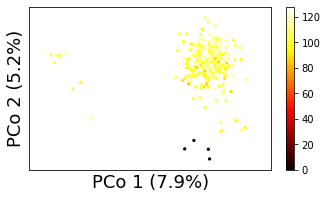

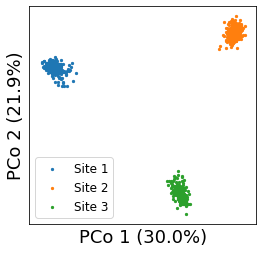

-------------------Metabolically overlapping-------------------


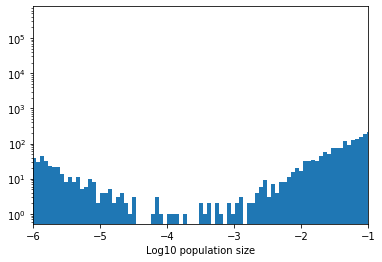

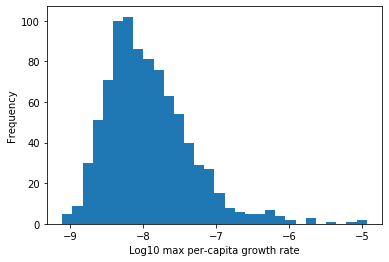

1


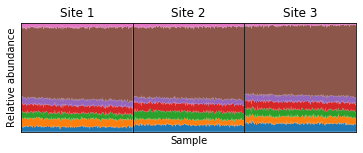

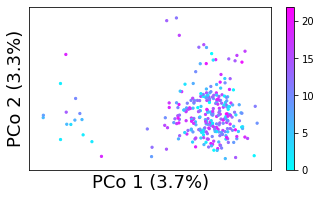

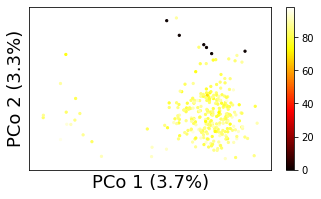

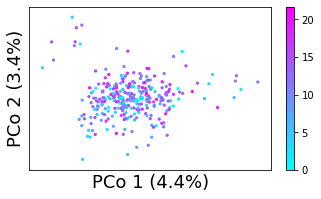

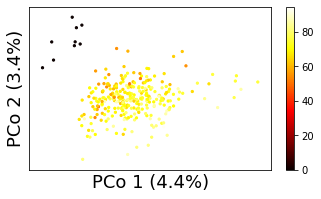

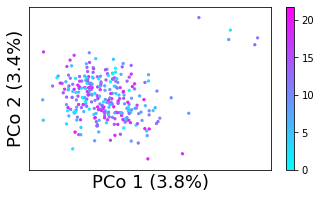

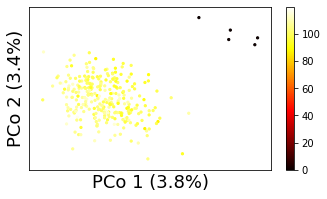

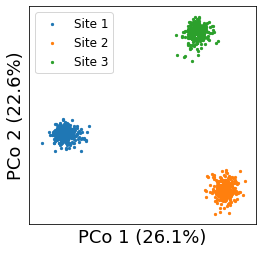

-------------------No taxonomic structure-------------------


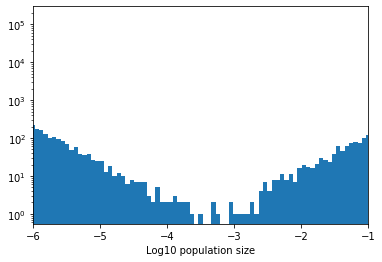

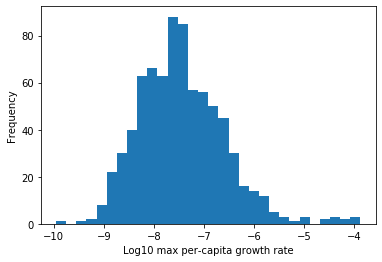

13


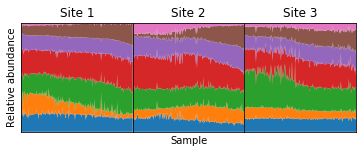

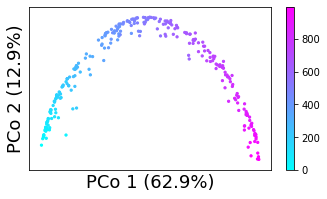

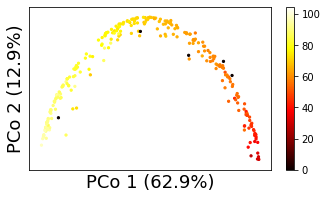

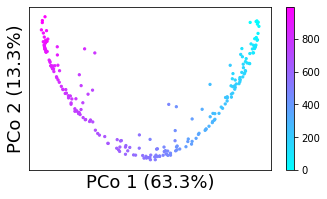

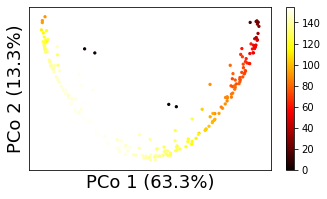

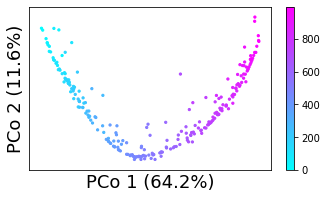

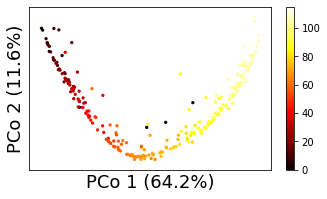

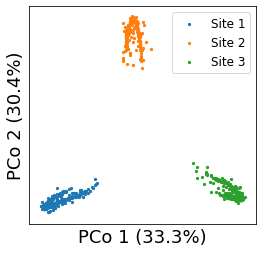

In [2]:
S = 4900 #Or 2500 for main plots
for exp in ['Simple environments','Complex environments','Metabolically overlapping','No taxonomic structure']:
    if S == 4900 and exp == 'Simple environments':
        thresh = 10**(-2.5)
        print('thresh = '+str(thresh))
    else:
        thresh = 1e-4
        
    print('-------------------'+exp+'-------------------')
    with open(filename('comm',exp,S),'rb') as f:
        N,R,params,R0,metadata = pickle.load(f)
    
    #Drop trials that failed
    metadata = metadata.loc[N.sum()>0]
    R0 = R0.T.loc[N.sum()>0].T
    N = N.T.loc[N.sum()>0].T
    
    #Plot population sizes to confirm threshold value
    Nval = N.values.reshape(-1)
    plt.hist(np.log10(Nval[Nval>0]),bins=200)
    plt.gca().set_yscale('log')
    plt.gca().set_xlim((-6,-1))
    plt.gca().set_xlabel('Log10 population size')
    plt.show()
    
    #Drop trials that failed to converge
    err_list = pd.Series()
    for well in N.keys():
        params['R0'] = R0[well]
        Nwell = N[well].values
        Rwell = R[well].values
        Nwell[Nwell<thresh] = 0
        err = dNdt(N[well].values,R[well].values,params)
        err = err[err != 0]
        err_list.loc[well] = np.max(np.abs(err/Nwell[Nwell>thresh]))
    np.log10(err_list).plot.hist(bins=30)
    plt.gca().set_xlabel('Log10 max per-capita growth rate')
    plt.show()
    converged = err_list<1e-5
    print((err_list >= 1e-5).sum())
    N = N.T[converged].T
    R0 = R0.T[converged].T
    metadata = metadata[converged]
    
    #Make stacked bar plots
    fig,ax=plt.subplots(1,3,figsize=(6,2),sharey=True)
    fig.subplots_adjust(wspace=0)
    k=0
    for env in np.sort(list(set(metadata['Environment']))):
        data = N.T.loc[metadata['Environment']==env].T.groupby(level=0).sum()
        data = data/data.sum()
        #R0_env = R0.T[metadata['Environment']==env].T
        #R0_max = R0_env.T.mean().idxmax()
        #R0_ind = pd.DataFrame(R0_env.loc[R0_max].values,index=R0_env.loc[R0_max].index,columns=['R0'])
        #data = data.T.join(R0_ind).sort_values('R0').T.drop('R0')
        if len(data)>1:
            data = data.T.sort_values('F5').T
        #Make plots
        StackPlot(data,ax=ax[k],drop_zero=False)
        ax[k].set_title(env)
        k+=1
    ax[1].set_xlabel('Sample')
    ax[0].set_ylabel('Relative abundance')
    pdf = bpdf.PdfPages('Plots/stackplot_'+'_'.join(exp.split(' ')+['S',str(S)])+'.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()
    
    #Do PCoA within each environment
    for env in np.sort(list(set(metadata['Environment']))):
        R0_env = R0.T[metadata['Environment']==env].T
        R0_max = R0_env.T.mean().idxmax()
        R0_ind = R0_env.loc[R0_max]
        N_sugars = N.T[metadata['Environment']==env].T
        N_sugars[N_sugars<1e-4] = 0
        #Make distance matrix
        HMP_dist = squareform(pdist(N_sugars.T,metric='jensenshannon'))
        #Compute PCoA and attach sample labels
        PCout = pcoa(HMP_dist)
        PCout.samples.index = N_sugars.T.index
        #Save explained variance
        explained_variance = np.around(PCout.proportion_explained.values*100,decimals=1)
        PCout = PCout.samples
        fig,ax=plt.subplots(figsize=(7,3))
        fig.subplots_adjust(left=0.3)
        if S == 2500:
            PCout.plot.scatter('PC2','PC1',ax=ax,s=5,c=R0_ind,cmap='cool',colorbar=True,vmin=0)
            ax.set_ylabel('PCo 1 ('+str(explained_variance[0])+'%)',fontsize=18)
            ax.set_xlabel('PCo 2 ('+str(explained_variance[1])+'%)',fontsize=18)
            ax.invert_yaxis()
        else:
            PCout.plot.scatter('PC1','PC2',ax=ax,s=5,c=R0_ind,cmap='cool',colorbar=True,vmin=0)
            ax.set_xlabel('PCo 1 ('+str(explained_variance[0])+'%)',fontsize=18)
            ax.set_ylabel('PCo 2 ('+str(explained_variance[1])+'%)',fontsize=18)
        ax.set_xticks(())
        ax.set_yticks(())
        pdf = bpdf.PdfPages('Plots/PCoA_site'+env[-1]+'_'+'_'.join(exp.split(' ')+['S',str(S)])+'_cenv.pdf')
        pdf.savefig(fig)
        pdf.close()
        plt.show()
        
        fig,ax=plt.subplots(figsize=(7,3))
        fig.subplots_adjust(left=0.3)
        dominant=N_sugars.T.sum().idxmax()
        if S == 2500:
            PCout.plot.scatter('PC2','PC1',ax=ax,s=5,c=N_sugars.loc[dominant],cmap='hot',vmin=0,colorbar=True)
            ax.set_ylabel('PCo 1 ('+str(explained_variance[0])+'%)',fontsize=18)
            ax.set_xlabel('PCo 2 ('+str(explained_variance[1])+'%)',fontsize=18)
            ax.invert_yaxis()
        else:
            PCout.plot.scatter('PC1','PC2',ax=ax,s=5,c=N_sugars.loc[dominant],cmap='hot',vmin=0,colorbar=True)
            ax.set_xlabel('PCo 1 ('+str(explained_variance[0])+'%)',fontsize=18)
            ax.set_ylabel('PCo 2 ('+str(explained_variance[1])+'%)',fontsize=18)
        ax.set_xticks(())
        ax.set_yticks(())
        pdf = bpdf.PdfPages('Plots/PCoA_site'+env[-1]+'_'+'_'.join(exp.split(' ')+['S',str(S)])+'_cspec.pdf')
        pdf.savefig(fig)
        pdf.close()
        plt.show()
        
    #Do PCoA for all samples together
    #Make distance matrix
    HMP_dist = squareform(pdist(N.T.values,metric='jensenshannon'))
    #Compute PCoA and attach sample labels
    PCout = pcoa(HMP_dist)
    PCout.samples.index = N.T.index
    #Save explained variance
    explained_variance = np.around(PCout.proportion_explained.values*100,decimals=1)
    #Make dataframe with metadata
    PCout = PCout.samples.join(metadata)
    colors = sns.color_palette()
    #Plot groups
    groups = PCout.groupby('Environment')
    fig,ax=plt.subplots(figsize=(4.5,4))
    fig.subplots_adjust(left=0.2)
    k=0
    for name, group in groups:
        group.plot.scatter('PC1','PC2',ax=ax,label='Site '+str(k+1),color = colors[k],s=5)
        k+=1
    ax.legend(fontsize=12)
    ax.set_xlabel('PCo 1 ('+str(explained_variance[0])+'%)',fontsize=18)
    ax.set_ylabel('PCo 2 ('+str(explained_variance[1])+'%)',fontsize=18)
    ax.set_xticks(())
    ax.set_yticks(())
    pdf = bpdf.PdfPages('Plots/PCoA_all_'+'_'.join(exp.split(' ')+['S',str(S)])+'.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()

## Plot Dissimilarity-Overlap Curve

### Same body site

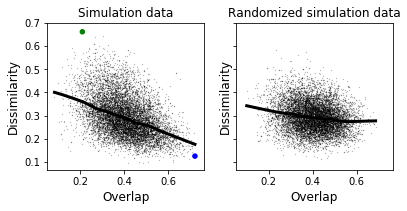

Most overlap:
6593    0.721838
4605    0.716225
3988    0.713374
dtype: float64
Most dissimilarity:
6874    0.664632
8208    0.661828
3524    0.644995
dtype: float64


In [11]:
with open('data/DOC_same.dat','rb') as f:
    pairs,Olist,Dlist,Olist_null,Dlist_null = pickle.load(f)
examples=np.asarray([8208,6593])
    
#Make and annotate plots
fig,ax=plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,3))
fig.subplots_adjust(left=0.2,right=0.8,bottom=0.2)
#subsample = np.random.choice(np.arange(len(Olist),dtype=int),size=10000)
subsample = np.arange(len(Olist),dtype=int)

ax[0].scatter(Olist[subsample],Dlist[subsample],c='k',s=0.05,alpha=0.5)
ax[0].scatter(Olist[examples],Dlist[examples],c=['g','b'],s=20)
ax[0].set_xlabel('Overlap',fontsize=12)
ax[0].set_ylabel('Dissimilarity',fontsize=12)
out_real = lowess(Dlist[subsample],Olist[subsample],return_sorted=True,frac=0.2)
ax[0].plot(out_real[:,0],out_real[:,1],'k',lw=3)
ax[0].set_title('Simulation data',fontsize=12)
#ax[0].set_xlim((0,0.4))

ax[1].scatter(Olist_null[subsample],Dlist_null[subsample],c='k',s=0.05,alpha=0.5)
ax[1].set_xlabel('Overlap',fontsize=12)
ax[1].set_ylabel('Dissimilarity',fontsize=12)
out_null = lowess(Dlist_null[subsample],Olist_null[subsample],return_sorted=True,frac=0.2)
ax[1].plot(out_null[:,0],out_null[:,1],'k',lw=3)
ax[1].set_title('Randomized simulation data',fontsize=12)
#ax[1].set_ylim((0.1,0.6))
    
pdf = bpdf.PdfPages('Plots/DOC_same.pdf')
pdf.savefig(fig)
pdf.close()

plt.show()

#Find candidate examples
print('Most overlap:')
O_data = pd.Series(Olist,index=range(len(Olist)))
print(O_data.sort_values(ascending=False).iloc[:3])
print('Most dissimilarity:')
D_data = pd.Series(Dlist,index=range(len(Dlist)))
print(D_data.sort_values(ascending=False).iloc[:3])

### Different body sites

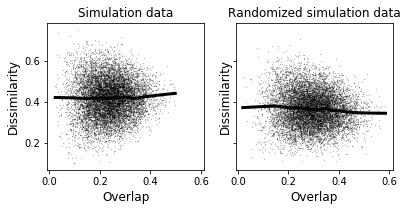

In [57]:
with open('data/DOC_diff.dat','rb') as f:
    pairs,Olist,Dlist,Olist_null,Dlist_null = pickle.load(f)

#Make and annotate plots
fig,ax=plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,3))
fig.subplots_adjust(left=0.2,right=0.8,bottom=0.2)
#subsample = np.random.choice(np.arange(len(Olist),dtype=int),size=10000)
subsample = np.arange(len(Olist),dtype=int)

ax[0].scatter(Olist[subsample],Dlist[subsample],c='k',s=0.05,alpha=0.5)
ax[0].set_xlabel('Overlap',fontsize=12)
ax[0].set_ylabel('Dissimilarity',fontsize=12)
out_real = lowess(Dlist[subsample],Olist[subsample],return_sorted=True,frac=0.2)
ax[0].plot(out_real[:,0],out_real[:,1],'k',lw=3)
ax[0].set_title('Simulation data',fontsize=12)
#ax[0].set_xlim((0,0.4))

ax[1].scatter(Olist_null[subsample],Dlist_null[subsample],c='k',s=0.05,alpha=0.5)
ax[1].set_xlabel('Overlap',fontsize=12)
out_null = lowess(Dlist_null[subsample],Olist_null[subsample],return_sorted=True,frac=0.2)
ax[1].plot(out_null[:,0],out_null[:,1],'k',lw=3)
ax[1].set_ylabel('Dissimilarity',fontsize=12)
ax[1].set_title('Randomized simulation data',fontsize=12)
#ax[1].set_ylim((0.1,0.6))
    
pdf = bpdf.PdfPages('Plots/DOC_diff.pdf')
pdf.savefig(fig)
pdf.close()

plt.show()

### Look at Lotka-Volterra coefficients

Scatter plot of all differences

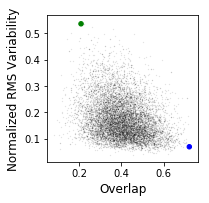

In [12]:
with open('data/LV_params.dat','rb') as f:
    K_diff = pickle.load(f)
with open('data/DOC_same.dat','rb') as f:
    pairs,Olist,Dlist,Olist_null,Dlist_null = pickle.load(f)
examples=np.asarray([8208,6593])
    
#alpha_diff = np.asarray(alpha_diff)
K_diff = np.asarray(K_diff)
    
#Make and annotate plots
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.2,bottom=0.2)
#subsample = np.random.choice(np.arange(len(Olist),dtype=int),size=20000)
subsample = np.arange(len(Olist),dtype=int)

ax.scatter(Olist[subsample],K_diff[subsample],c='k',s=0.05,alpha=0.2)
ax.scatter(Olist[examples],K_diff[examples],c=['g','b'],s=20)
ax.set_xlabel('Overlap',fontsize=12)
ax.set_ylabel('Normalized RMS Variability',fontsize=12)
#ax[1].set_ylim((0.1,0.6))
    
pdf = bpdf.PdfPages('Plots/universal.pdf')
pdf.savefig(fig)
pdf.close()

plt.show()

Plot one example

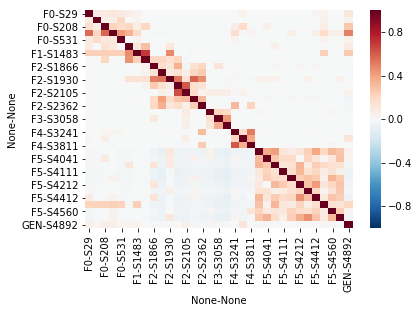

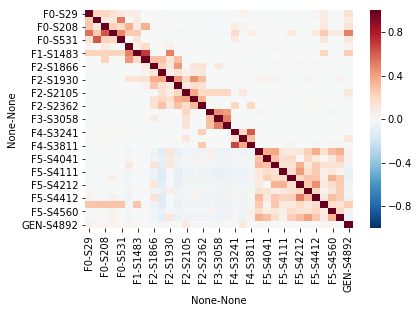

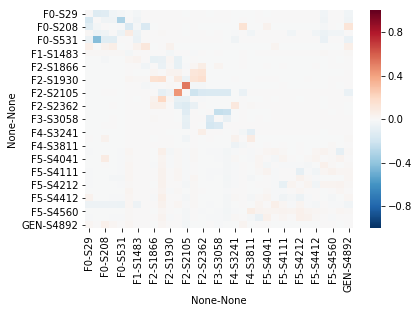

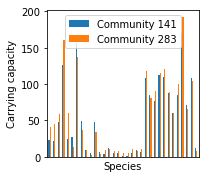

In [14]:
S = 2500
exp = 'Simple environments'
env = 'Site 1'
thresh=1e-4

#Load the data
with open('data/DOC_same.dat','rb') as f:
    pairs,Olist,Dlist,Olist_null,Dlist_null = pickle.load(f)
with open(filename('comm',exp,S),'rb') as f:
    N,R,params,R0,metadata = pickle.load(f)
N = N.T[metadata['Environment']==env].T
R = R.T[metadata['Environment']==env].T
R0 = R0.T[metadata['Environment']==env].T
R0_max = R0.T.mean().idxmax()
metadata = pd.DataFrame(R0.loc[R0_max].values,index=R0.loc[R0_max].index,columns=['alpha'])
#Remove failed runs
metadata = metadata[np.isnan(N).sum()==0]
R = R.T[np.isnan(N).sum()==0].T
R0 = R0.T[np.isnan(N).sum()==0].T
N = N.T[np.isnan(N).sum()==0].T
wells = N.T.index

#Get well names
#item = 8208 #Other example
item = 6593 
well1 = wells[pairs[item][0]]
well2 = wells[pairs[item][1]]

#Make interaction matrix for well 1
M = len(R)
D = pd.DataFrame(params['D'],index=R.index,columns=R.index)
c = pd.DataFrame(params['c'],index=N.index,columns=R.index)
Q = np.eye(M) - D*params['l']
A = np.eye(M) + Q*(c.T.dot(N[well1]))
Ainv = pd.DataFrame(np.linalg.inv(A),index=A.index,columns=A.keys())
alpha1 = (c*(1-params['l'])).dot(Ainv).dot(Q).dot((c*R[well1]).T)
#Make interaction matrix for well 2
A = np.eye(M) + Q*(c.T.dot(N[well2]))
Ainv = pd.DataFrame(np.linalg.inv(A),index=A.index,columns=A.keys())
alpha2 = (c*(1-params['l'])).dot(Ainv).dot(Q).dot((c*R[well2]).T)
#Keep shared species
alpha1 = alpha1.loc[(N[well1]>thresh)&(N[well2]>thresh)]
alpha1 = alpha1.T.loc[(N[well1]>thresh)&(N[well2]>thresh)].T
alpha2 = alpha2.loc[(N[well1]>thresh)&(N[well2]>thresh)]
alpha2 = alpha2.T.loc[(N[well1]>thresh)&(N[well2]>thresh)].T

#Plot interaction matrix for well 1
fig,ax=plt.subplots()
sns.heatmap((alpha1.T/np.diag(alpha1)).T,cmap='RdBu_r',vmin=-1,vmax=1,ax=ax)
pdf = bpdf.PdfPages('Plots/alpha1_'+str(item)+'.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Plot interaction matrix for well 2
fig,ax=plt.subplots()
sns.heatmap((alpha2.T/np.diag(alpha2)).T,cmap='RdBu_r',vmin=-1,vmax=1,ax=ax)
pdf = bpdf.PdfPages('Plots/alpha2_'+str(item)+'.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Plot difference between interaction matrices
fig,ax=plt.subplots()
sns.heatmap((alpha1.T/np.diag(alpha1)-(alpha2.T/np.diag(alpha2))).T,cmap='RdBu_r',vmin=-1,vmax=1,ax=ax)
pdf = bpdf.PdfPages('Plots/alphadiff_'+str(item)+'.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Compute carrying capacities
K1 = alpha1.dot(N[well1].loc[(N[well1]>thresh)&(N[well2]>thresh)])/np.diag(alpha1) - params['m'][(N[well1]>thresh)&(N[well2]>thresh)]
K2 = alpha2.dot(N[well2].loc[(N[well1]>thresh)&(N[well2]>thresh)])/np.diag(alpha2) - params['m'][(N[well1]>thresh)&(N[well2]>thresh)]
K = pd.DataFrame(K1,index=K1.index,columns=['Community '+well1[1:]]).join(pd.DataFrame(K2,index=K2.index,columns=['Community '+well2[1:]]))
#Make bar plot
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.2,bottom=0.2)
K.plot.bar(ax=ax)
ax.set_xticks(())
ax.set_xlabel('Species')
ax.set_ylabel('Carrying capacity')
pdf = bpdf.PdfPages('Plots/K_example_'+str(item)+'.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Modular assembly

Variance score: 0.83


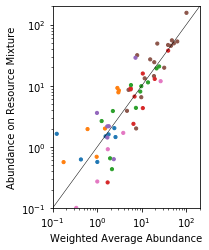

In [50]:
exp = 'Simple environments'
S = 5000
env = 'Site 2'
thresh=1e-4

#Load and select data
with open(filename('comm',exp,S),'rb') as f:
    N,R,params,R0,metadata = pickle.load(f)
N = N.T[metadata['Environment']==env].T
R = R.T[metadata['Environment']==env].T
R0 = R0.T[metadata['Environment']==env].T
R0_max = R0.T.mean().idxmax()
metadata = pd.DataFrame(R0.loc[R0_max].values,index=R0.loc[R0_max].index,columns=['alpha'])
#Remove failed runs
metadata = metadata[np.isnan(N).sum()==0]
R = R.T[np.isnan(N).sum()==0].T
R0 = R0.T[np.isnan(N).sum()==0].T
N = N.T[np.isnan(N).sum()==0].T
metadata = ((metadata-metadata.min())/(metadata.max()-metadata.min())).squeeze()

#Format data and compute averages
wells = N.keys()
extremes = [metadata.idxmin(),metadata.idxmax()]
average = np.asarray([(1-metadata[well])*N[extremes[0]].values+metadata[well]*N[extremes[1]].values for well in wells]).T
N_df = N.copy()
N = N.values
average = average[:,np.argmin(np.abs(metadata-0.5).values)]
N = N[:,np.argmin(np.abs(metadata-0.5).values)]
N = N[:,np.newaxis]
average = average[:,np.newaxis]

#Plot
fig,ax=plt.subplots(figsize=(3,4))
fig.subplots_adjust(left=0.22,bottom=0.18)
Nmin = 1e-1
Nmax = 200
common = []
for k in range(len(N.T)):
    common.append(np.asarray(list(set(np.where(average[:,k]>thresh)[0]).intersection(set(np.where(N[:,k]>thresh)[0])))))
    families = N_df.iloc[common[k]].index.levels[0][N_df.iloc[common[k]].index.codes[0]].values
    families[families=='GEN'] = 'F6'
    for j in range(len(families)):
        label = int(families[j][-1])
        families[j] = colors[label]
    ax.scatter(average[common[k],k],N[common[k],k],s=10,c=families)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([Nmin,Nmax])
ax.set_ylim([Nmin,Nmax])
ax.set_ylabel('Abundance on Resource Mixture')
ax.set_xlabel('Weighted Average Abundance')

#Make flat arrays for computing R^2
average_all = np.asarray([average[common[k][j],k] for k in range(len(average.T)) for j in range(len(common[k]))])
mix_all = np.asarray([N[common[k][j],k] for k in range(len(average.T)) for j in range(len(common[k]))])

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(mix_all, average_all))

#Plot additive model
ax.plot([Nmin,Nmax],np.asarray([Nmin,Nmax]),'k',lw=0.5)
pdf = bpdf.PdfPages('Plots/modularity_'+'_'.join(exp.split(' ')+['env',env[-1],'S',str(S)])+'.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()